# Run level 2A, 2B and 3 pipelines on LRS-SLIT data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) December 5th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS-SLIT data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook are a dithered (nodded) MIRISim simulation of a point source with a power-law spectrum (alpha=0) plus emission lines. The following steps are applied:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps (Spec2Pipeline), including background subtraction using the nods, spectral extraction

- manual conversion of extracted spectrum to Jy using SRF


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'LRS-SLIT_demo_data'
input_dir = 'LRS-SLIT_demo_data'

# load all files including the background observation
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipeline'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-FIXEDSLIT	 P750L	 FULL	 2	 50	 FAST	 277.5



Filename: LRS-SLIT_demo_data/det_image_1_MIRIMAGE_P750Lexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     109   ()      
  1  SCI           1 ImageHDU        65   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     18   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679309,)   uint8   


#### show the last frame of the first integration for each file

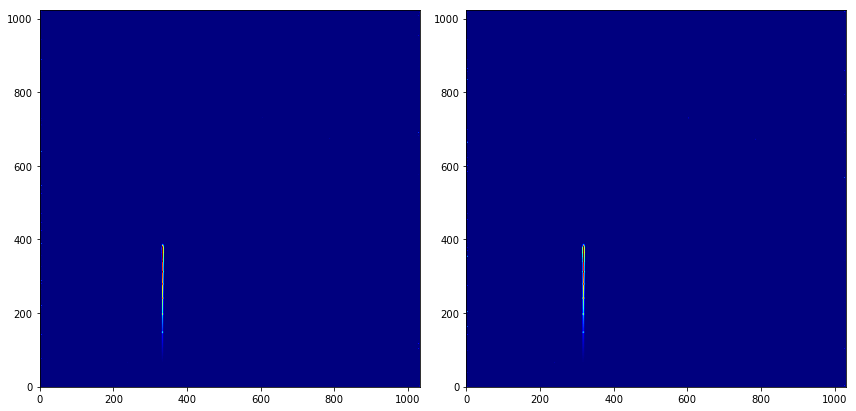

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

for n, f in enumerate(input_files):
    with datamodels.open(f) as in_dm:
        axs[n].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=5e4))
        axs[n].set_facecolor('black')

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'

In [6]:
for f in input_files:
    Detector1Pipeline.call(f, save_results=True, output_dir=output_dir)


2017-12-13 12:36:40,069 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2017-12-13 12:36:40,070 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2017-12-13 12:36:40,072 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2017-12-13 12:36:40,073 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2017-12-13 12:36:40,075 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-13 12:36:40,076 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-13 12:36:40,079 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-13 12:36:40,081 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-13 12:36:40,082 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-13 12:36:40,084 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-13 12

2017-12-13 12:37:32,482 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2017-12-13 12:37:41,274 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2017-12-13 12:37:41,426 - stpipe.Detector1Pipeline.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-12-13 12:37:41,480 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x117815ac8>,).
2017-12-13 12:37:41,508 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-13 12:37:41,509 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-13 12:37:41,510 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-13 12:37:41,510 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-13 12:37:41,511 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-13 12:37:42,220 - stpipe.Detector1Pipeline.ref

2017-12-13 12:43:59,429 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-13 12:43:59,430 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-13 12:43:59,432 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-13 12:43:59,434 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-13 12:43:59,436 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-13 12:43:59,437 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-13 12:43:59,438 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-13 12:43:59,441 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-13 12:43:59,442 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-13 12:43:59,444 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-13 

2017-12-13 12:44:55,613 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-13 12:44:55,613 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-13 12:44:55,614 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-13 12:44:55,615 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-13 12:44:55,616 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-13 12:44:56,296 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration
2017-12-13 12:44:57,620 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in
2017-12-13 12:44:58,620 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-13 12:44:58,776 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-13 12:44:58,777 - stpipe.Detector1Pipeline.jump - INFO - Pr

#### Quick check of the pipeline steps applied in the output:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


The bkg_subtract subtract step requires an association file defining the source and background exposures. At the moment, there is no easy way to create one, so we define it manually in a cell and write to the association json file. 

Note that the first nod in the MIRISim simulations is actually the background nod so we define this in the association file.

In [9]:
import json

data = {
        "degraded_status": "No known degraded exposures in association.",
        "asn_rule": "DMS_Level3_Base",
        "asn_pool": "none",
        "asn_type": "None",
        "constraints": "No constraints",
        "program": "none",
        "code_version": "0.7.1.beta5",
        "asn_id": "a3001",
        "products": [
        {
            "name": "lrs_bgsub_1",
            "members": [
                {
                    "expname": "LRS-SLIT_demo_data_pipeline/det_image_2_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "LRS-SLIT_demo_data_pipeline/det_image_1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ],
    "target": "none"
}

with open('LRS_lvl2_asn.json', 'w') as outfile:  
    json.dump(data, outfile)

#### run pipeline
We pass the level 2 assocation file. The output is contained in the dm_2B data model and saved to a fits file ending in '_cal.fits'.

The call to the pipeline will also extract a spectrum from this _cal.fits file (ending in _x1d.fits). 

In [10]:
Spec2Pipeline.call('LRS_lvl2_asn.json', save_results=True, output_dir=output_dir, steps={'extract_1d':{'save_results':True}})


2017-12-13 12:51:23,086 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-12-13 12:51:23,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-12-13 12:51:23,089 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-12-13 12:51:23,090 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-12-13 12:51:23,092 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-12-13 12:51:23,094 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2017-12-13 12:51:23,096 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-12-13 12:51:23,097 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2017-12-13 12:51:23,098 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-12-13 12:51:23,100 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2017-12-13 12:51:2

2017-12-13 12:51:23,540 - stpipe.Spec2Pipeline - INFO - Prefetch for RESOL reference file is 'N/A'.
2017-12-13 12:51:23,541 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2017-12-13 12:51:23,541 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0001.fits'.
2017-12-13 12:51:23,542 - stpipe.Spec2Pipeline - INFO - Prefetch for STRAYMASK reference file is 'N/A'.
2017-12-13 12:51:23,543 - stpipe.Spec2Pipeline - INFO - Prefetch for V2V3 reference file is 'N/A'.
2017-12-13 12:51:23,543 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.
2017-12-13 12:51:23,544 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2017-12-13 12:51:23,597 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('LRS_lvl2_asn.json',).
2017-12-13 12:51:23,598 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
20

2017-12-13 12:51:27,654 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2017-12-13 12:51:27,655 - stpipe.Spec2Pipeline - INFO - Finished processing product lrs_bgsub_1
2017-12-13 12:51:27,656 - stpipe.Spec2Pipeline - INFO - Step.save_model LRS-SLIT_demo_data_pipeline/lrs_bgsub_1_cal.fits
2017-12-13 12:51:27,891 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2017-12-13 12:51:27,892 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


### check of output

We can have a look at the steps applied to the level 2B file in the pipeline

In [11]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('bkg_subtract: %s' % dm.meta.cal_step.back_sub)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
bkg_subtract: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
photom: COMPLETE


While the photom step attaches the SRF to the _cal.fits file, it does not actually apply it so we must manually convert the extracted spectrum from DN/s to Jy using the SRF. We can look at the SRF while is located in the 'relsens' object in the metadata.

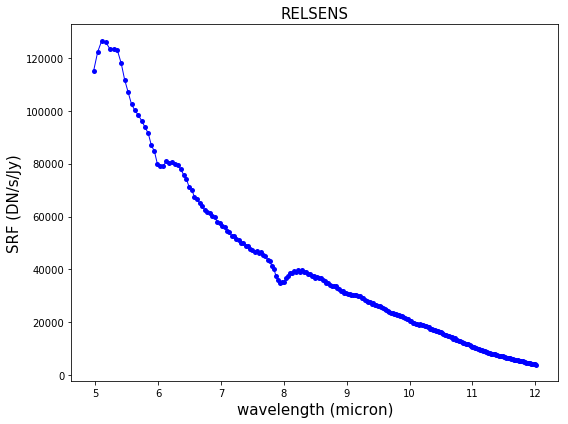

In [12]:
with datamodels.open(level2B_files[0]) as dm:  
    #print(dm.relsens)
    relsens = np.array(dm.relsens, dtype=[('wavelength', 'f4'), ('response', 'i8')])
    # plot--------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))

    # plot input and output ramps of the first integration
    axs.plot(relsens['wavelength'], relsens['response'], c='b', marker='o', markersize=2, 
             markeredgewidth=3, linestyle='-', linewidth=1, label='relsens')
    axs.set_title('RELSENS', fontsize=15)
    axs.set_xlabel('wavelength (micron)', fontsize=15)
    axs.set_ylabel('SRF (DN/s/Jy)', fontsize=15)

    plt.tight_layout(h_pad=0)
    plt.show()

#### plot the spectrum
Using the SRF, we can flux calibrate and plot the extracted spectrum

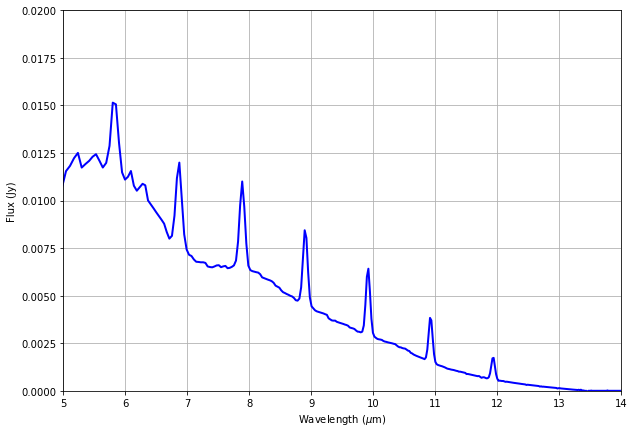

In [13]:
spec_file = glob.glob(os.path.join(output_dir,"*x1d.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# convert the flux to Jy
response_at_data = np.interp(dm.spec[0].spec_table['WAVELENGTH'][1:-1], relsens['wavelength'], relsens['response'])
flux_Jy = dm.spec[0].spec_table['FLUX'][1:-1] / response_at_data

# plot the spectrum 
axs.plot(dm.spec[0].spec_table['WAVELENGTH'][1:-1], flux_Jy, c='b', marker='.', 
         markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux (Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')
axs.set_xlim(5.0,14.0)
axs.set_ylim(0,0.02)
plt.grid()
plt.show()